<a href="https://colab.research.google.com/github/MoriyaBitton/Machine_learning/blob/main/Final_Project_Machin_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>**Final Project - Machin Learning**</u>

---



---



## <u>**Project Objective**</u>

*   Check whether ML algorithms can classify images without image pre-processin

*   Extract feature vector from images using Auto-Encoder, use it as input to ML algorithms, and compare algorithms classification results.

*   Reduce image size with PCA algorithm, and use it as input to ML classification algorithms, and compare their results, to the Auto-Encoder method
results.

*   Use both PCA and Auto-Encoder and compare to previous results.

---



---



### <u>Impotrs</u>

---



---



In [213]:
# Basic 
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Dataset 
from keras.datasets import mnist

# Model 
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.utils import np_utils
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Model

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop

# Confusion Matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

### <u>MNIST - DataSet</u>

*   MNIST set consists of a large collection of handwritten digits.

*   A training set of 60,000 examples, and a test set of 10,000 examples, contain 70,000 28 x 28 handwritten images.

*   This is a subset of NIST's larger collection. 

*   The dataset has already been divided into training and testing sets.

---




[Wikipedia page](https://en.wikipedia.org/wiki/MNIST_database)


In [214]:
# loading

(x_train, y_train), (x_test, y_test) = mnist.load_data()

> <u>Normalize and reshape the data:</u>\
> As we only need images from the dataset to encode and decode, we won't use the labels.



In [216]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [217]:
# shape of dataset

print('X_train: ' + str(x_train.shape), '\tY_train: ' + str(y_train.shape))
print('X_test:  ' + str(x_test.shape), '\tY_test:  ' + str(y_test.shape))

X_train: (60000, 784) 	Y_train: (60000,)
X_test:  (10000, 784) 	Y_test:  (10000,)


In [218]:
def plotting(history):
    colors = {'loss':'r', 'accuracy':'b', 'val_loss':'m', 'val_accuracy':'g'}
    plt.figure(figsize=(10,6))
    plt.xlabel("Epoch")

    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

## <u>**Auto-Encoded Model**</u>


An Auto-Encoder is a type of artificial neural network used to learn efficient
coding of unlabeled data. 

An Auto-Encoder has two main parts:


1.   <u>Encoder</u> that maps the input into the code.

2.   <u>Decoder</u> that maps the code to a reconstruction of the input.


We will only use the encoder part of the network for image code.

---



---





In [220]:
y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test = keras.utils.np_utils.to_categorical(y_test, 10)

#### **Neural Network - Original Data**

In [221]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

Test loss:23.32%
Test accuracy:98.25%


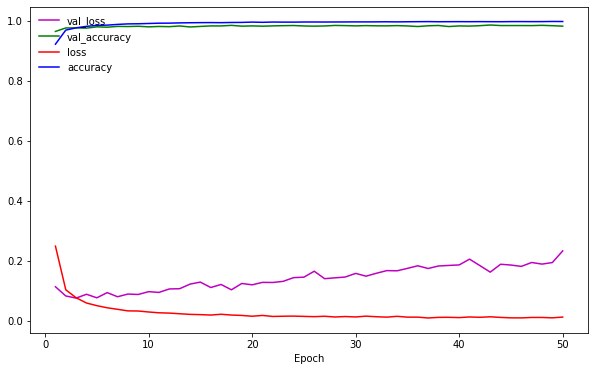

In [223]:
print("Test loss:{:.2f}%".format(score[0]*100))
print("Test accuracy:{:.2f}%".format(score[1]*100))

plotting(history.history)

#### <u>**Autoencoder Model**</u>

In [224]:
encoding_dim = 32  

input_img = tf.keras.Input(shape=(784,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.Model(input_img, decoded)

# Encoder
encoder = tf.keras.Model(input_img, encoded)

# Decoder
encoded_input = tf.keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.Model(encoded_input, decoder_layer(encoded_input))

# Autoencoder
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test))

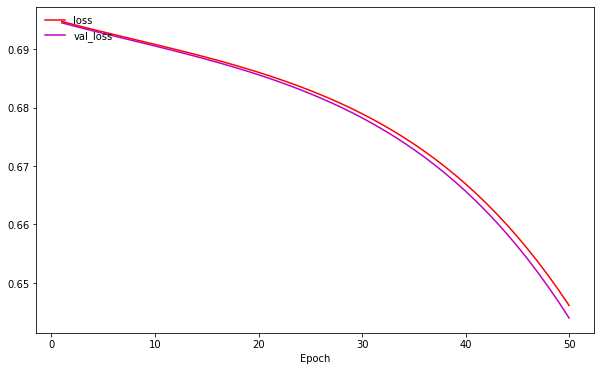

In [226]:
plotting(history.history)

In [227]:
encoded_imgs_train = encoder.predict(x_train)
encoded_imgs_test = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs_test)

#### **Neural Network - Encoded Data**

In [228]:
encoded_imgs_train_normalized = encoded_imgs_train / np.max(encoded_imgs_train)
encoded_imgs_test_normalized = encoded_imgs_test / np.max(encoded_imgs_test)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(encoding_dim,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 512)               16896     
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_38 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 10)                5130      
Total params: 284,682
Trainable params: 284,682
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(encoded_imgs_train_normalized, y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                    validation_data=(encoded_imgs_test_normalized, y_test))

score = model.evaluate(encoded_imgs_test_normalized, y_test, verbose=0)

Test loss:40.524%
Test accuracy:89.870%


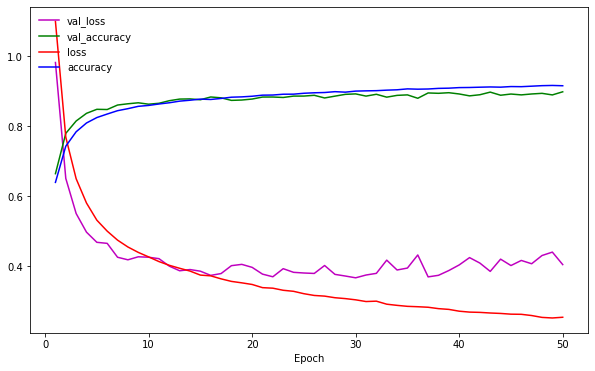

In [230]:
print("Test loss:{:.3f}%".format(score[0]*100))
print("Test accuracy:{:.3f}%".format(score[1]*100))

plotting(history.history)

## <u>**PCA- Principal Component Analysis**</u>


A PCA is an extension of dimensionality reduction that is applied to the visualization of high-dimensional data.

By reducing the dimensionality of the dataset, we get n-dimensional data, where n<d.\
The threshold is usually set at d>3.

The spread of data on one axis is very large, but the spread (variance) on another axis is relatively small.

Therefore, we can skip dimensions with less variance, as standardized columns can be used to visualize data with less information.


---



---





In [231]:
pca = PCA(32)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
approximation = pca.inverse_transform(pca_test)

### <u>**Plotting**</u>


Original Data:


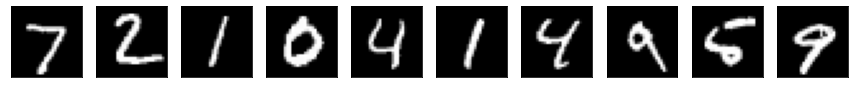


Encoded Data:


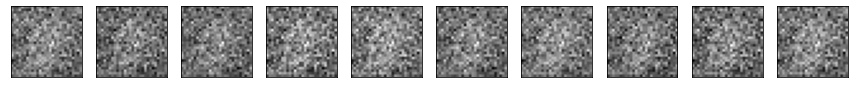


PCA Data:


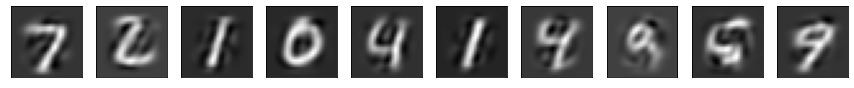

In [233]:
n = 10  

print("\nOriginal Data:")
plt.figure(figsize=(15, 5))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\nEncoded Data:")
plt.figure(figsize=(15, 5))
for i in range(n):    
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("\nPCA Data:")
plt.figure(figsize=(15, 5))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(approximation[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## <u>**Machine Learning and Deep Learning methods:**</u>

*   Logistic Regression

*   SVM

*   KNN

*   CNN

*   MLP



---



---



#### <u>**Logistic Regression**</u>

> In statistical analysis, logistic regression predicts whether a data set belongs to a predefined class based on prior observations.\
By using the sigmoid function, logistic regression can set model output from 0 to 1, and the logistic loss is applied to penalize data classification errors.



In [ ]:
# ORIGINAL DATA

clf_lr_org = LogisticRegression()
clf_lr_org.fit(x_train, np.argmax(y_train, axis=1))
acc_lr_org = clf_lr_org.score(x_test, np.argmax(y_test, axis=1))

# ENCODED DATA

clf_lr_enc = LogisticRegression()
clf_lr_enc.fit(encoded_imgs_train_normalized, np.argmax(y_train, axis=1))
acc_lr_enc = clf_lr_enc.score(encoded_imgs_test_normalized, np.argmax(y_test, axis=1))

# PCA DATA

clf_lr_pca = LogisticRegression()
clf_lr_pca.fit(pca_train, np.argmax(y_train, axis=1))
acc_lr_pca = clf_lr_pca.score(pca_test, np.argmax(y_test, axis=1))

In [242]:
print("\nLogistic Regression Accuracy\n",
      "\nOriginal Data:\t{:.2f}%".format(acc_lr_org*100),
      "\nEncoded Data:\t{:.2f}%".format(acc_lr_enc*100),
      "\nPCA Data:\t{:.2f}%".format(acc_lr_pca*100))


Logistic Regression Accuracy
 
Original Data:	92.56% 
Encoded Data:	72.19% 
PCA Data:	90.03%




> **Conclusions - Logistic Regression:**




#### <u>**SVM - Support vector machine**</u>

> The Support Vector Machine finds the hyperplane that labels the dataset using a linear model.\
Based on the constant margin from both sides of the hyperplane, the algorithm reduces the plane weights to find the closest point, creating the support vectors.\
Rather than learning the data itself, SVM learns the rules that the data represent instead of the data itself.

In [ ]:
# ORIGINAL DATA

clf_svm_org = LinearSVC()
clf_svm_org.fit(x_train, np.argmax(y_train, axis=1))
pred_svm_org = clf_svm_org.predict(x_test)
acc_svm_org = accuracy_score(np.argmax(y_test, axis=1), pred_svm_org)

# ENCODED DATA

clf_svm_enc = LinearSVC()
clf_svm_enc.fit(encoded_imgs_train_normalized, np.argmax(y_train, axis=1))
pred_svm_enc = clf_svm_enc.predict(encoded_imgs_test_normalized)
acc_svm_enc = accuracy_score(np.argmax(y_test, axis=1), pred_svm_enc)

# PCA DATA

clf_svm_pca = LinearSVC()
clf_svm_pca.fit(pca_train, np.argmax(y_train, axis=1))
pred_svm_pca = clf_svm_pca.predict(pca_test)
acc_svm_pca = accuracy_score(np.argmax(y_test, axis=1), pred_svm_pca)

In [241]:
print("\nSVM Accuracy\n",
      "\nOriginal Data:\t{:.2f}%".format(acc_svm_org*100),
      "\nEncoded Data:\t{:.2f}%".format(acc_svm_enc*100),
      "\nPCA Data:\t{:.2f}%".format(acc_svm_pca*100))


SVM Accuracy
 
Original Data:	91.80% 
Encoded Data:	72.07% 
PCA Data:	88.61%


> **Conclusions - SVM:**


#### <u>**KNN - K-Nearest Neighbors**</u>

> A k-nearest neighbor algorithm solves classification and regression problems by assuming that similar things exist nearby.\
Using a distance function, the algorithm classifies a new sample with the label of the k nearest neighbors whose distance is the smallest from the dataset.


In [238]:
# ORIGINAL DATA

clf_knn_org = KNeighborsClassifier()
clf_knn_org.fit(x_train, np.argmax(y_train, axis=1))
pred_knn_org = clf_knn_org.predict(x_test)
acc_knn_org = accuracy_score(np.argmax(y_test, axis=1), pred_knn_org)

# ENCODED DATA

clf_knn_enc = KNeighborsClassifier()
clf_knn_enc.fit(encoded_imgs_train_normalized, np.argmax(y_train, axis=1))
pred_knn_enc = clf_knn_enc.predict(encoded_imgs_test_normalized)
acc_knn_enc = accuracy_score(np.argmax(y_test, axis=1), pred_knn_enc)

# PCA DATA

clf_knn_pca = KNeighborsClassifier()
clf_knn_pca.fit(pca_train, np.argmax(y_train, axis=1))
pred_knn_pca = clf_knn_pca.predict(pca_test)
acc_knn_pca = accuracy_score(np.argmax(y_test, axis=1), pred_knn_pca)

In [240]:
print("\nKNN Accuracy\n",
      "\nOriginal Data:\t{:.2f}%".format(acc_knn_org*100),
      "\nEncoded Data:\t{:.2f}%".format(acc_knn_enc*100),
      "\nPCA Data:\t{:.2f}%".format(acc_knn_pca*100))


KNN Accuracy
 
Original Data:	96.88% 
Encoded Data:	83.19% 
PCA Data:	97.56%


> **Conclusions - KNN:**

#### <u>**CNN - Convolutional neural network**</u>

> Convolutional neural networks process data with a grid-like topology, such as images.\
CNN typically consists of three layers: a convolutional layer, a pooling layer, and a fully connected layer.\
The CNN's convolution layer performs a dot product between two matrices, where one matrix is the set of learnable parameters called a kernel.\
It combines three essential computer vision concepts: sparse interaction, parameter sharing, and equivariant representation.\
Following the convolution layer, the max pool layer reduces the input data size by selecting the maximum value,
followed by the nonlinear activation function such as sigmoid or relu, and finally, the fully connected layer.

#### <u>**MLP - Multilayer perceptron**</u>

> A multi-layer Perceptron is a supervised learning algorithm that learns a mapping function from M input dimensions to 0 output dimensions.\
With a set of features X and a target y, it can learn a nonlinear function approximator for classification or regression.\
Unlike logistic regression, it has one or more nonlinear layers between input and output, called hidden layers.\
MLP's advantage is that it can learn nonlinear models, but its major disadvantage is that it has a nonconvex loss function with more than one local minimum.\
As a result, validation accuracy can vary based on the initialization of random weights.